In [ ]:
# Please run them sequentially

In [15]:
import pandas as pd
import numpy as np
import torch
# import networkx as

In [161]:
# Reading the Common Fiber Matrix
df = pd.read_csv("./Training/Health/sub1/common_fiber_matrix.txt", sep=r'\s{2,}', header = None, engine= "python")

In [162]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,369.0,0.0,0.0,0.0,61.0,63.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0
1,0.0,885.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,...,6.0,27.0,6.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0
2,0.0,0.0,322.0,0.0,1.0,4.0,5.0,13.0,0.0,0.0,...,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,420.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,61.0,0.0,1.0,0.0,283.0,44.0,4.0,5.0,1.0,0.0,...,1.0,13.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


In [10]:
# Reading the Correaltion Matrix 
df1 = pd.read_csv("./Health/sub1/pcc_fmri_feature_matrix_0.txt", sep=r'\s{2,}', header = None, engine= "python")
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,1.000000,0.185440,0.151375,0.250663,0.776522,0.525474,0.293214,0.241949,0.578018,0.276833,...,0.142357,0.336353,0.153626,0.155396,0.055478,0.103497,0.395730,0.275700,0.309613,0.097228
1,0.185440,1.000000,0.694452,0.487408,0.064682,0.108765,0.469088,0.494603,0.370401,0.651730,...,0.761156,0.603990,0.538870,0.625471,0.329587,0.265079,0.670107,0.669366,0.565110,0.549320
2,0.151375,0.694452,1.000000,0.547573,-0.077481,0.376565,0.645094,0.809168,0.420624,0.741733,...,0.784963,0.633076,0.856808,0.615150,0.713551,0.453360,0.592644,0.626485,0.630771,0.689641
3,0.250663,0.487408,0.547573,1.000000,0.130882,0.213225,0.732999,0.696692,0.301806,0.555123,...,0.538949,0.542540,0.514387,0.487804,0.417431,0.106592,0.350506,0.353114,0.402946,0.564400
4,0.776522,0.064682,-0.077481,0.130882,1.000000,0.323488,0.252140,0.068372,0.455271,0.159310,...,0.088020,0.356693,-0.049489,0.141515,-0.164322,-0.040150,0.351809,0.243052,0.139270,0.030685


In [297]:
from torch_geometric.data import Data, DataLoader
from scipy.sparse import coo_matrix

# Function to get data from the folders and combining them to form the train, test and feature data
def get_data(dataset = "Training", feature = False):
    healthy = []
    patient = []
    if dataset == "Training" and feature == False:
        for i in range(1,11):
            healthy.append([np.genfromtxt('./'+dataset+'/Health/sub'+str(i)+'/common_fiber_matrix.txt'), 1])
            patient.append([np.genfromtxt('./'+dataset+'/Patient/sub'+str(i)+'/common_fiber_matrix.txt'), 0])
    
    elif dataset == "Testing" and feature == False:
        for i in range(1,6):
            healthy.append([np.genfromtxt('./'+dataset+'/Health/sub'+str(i)+'/common_fiber_matrix.txt'), 1])
            patient.append([np.genfromtxt('./'+dataset+'/Patient/sub'+str(i)+'/common_fiber_matrix.txt'), 0])
    
    elif dataset == "Training" and feature == True:
        for i in range(1,11):
            healthy.append([np.genfromtxt('./'+dataset+'/Health/sub'+str(i)+'/pcc_fmri_feature_matrix_0.txt'), 1])
            patient.append([np.genfromtxt('./'+dataset+'/Patient/sub'+str(i)+'/pcc_fmri_feature_matrix_0.txt'), 0])
    
    elif dataset == "Testing" and feature == True:
        for i in range(1,6):
            healthy.append([np.genfromtxt('./'+dataset+'/Health/sub'+str(i)+'/pcc_fmri_feature_matrix_0.txt'), 1])
            patient.append([np.genfromtxt('./'+dataset+'/Patient/sub'+str(i)+'/pcc_fmri_feature_matrix_0.txt'), 0])
            
    data = []
    for i in range(len(healthy)):
        data.append(healthy[i])
        data.append(patient[i])
    
    del healthy, patient
    return data

# Using the PyTorch Geometric's Data class to load the data into the Data class needed to create the dataset
def create_dataset(data, features = None):
    dataset_list = []
    for i in range(len(data)):
#         degree_matrix = np.diag(np.sum(data[i][0], axis=1))
#         degree_matrix = np.count_nonzero(data[i][0], axis=1)
#         feature_matrix = degree_matrix.reshape(150,1)
        degree_matrix = np.count_nonzero(data[i][0], axis=1).reshape(150,1)
        weight_matrix = np.diag(np.sum(data[i][0], axis=1)).diagonal().reshape(150,1)
        feature_matrix = np.hstack((degree_matrix, weight_matrix))
        edge_index_coo = coo_matrix(data[i][0])
        edge_index_coo = torch.tensor(np.vstack((edge_index_coo.row, edge_index_coo.col)), dtype = torch.long)
        if features != None:
#             print(features[i][0].shape)
            feature_matrix = features[i][0]
#         print(feature_matrix.shape)
        graph_data = Data(x = torch.tensor(feature_matrix, dtype = torch.float32), edge_index=edge_index_coo, y = torch.tensor(data[i][1]))
        dataset_list.append(graph_data)
    return dataset_list
    

## Method-1

In [299]:
train_data1 = get_data("Training")
test_data1 = get_data("Testing")

training_dataset1 = create_dataset(train_data1)
testing_dataset1 = create_dataset(test_data1)

train_loader1 = DataLoader(training_dataset1, batch_size=5, shuffle = True)
test_loader1 = DataLoader(testing_dataset1, batch_size=5, shuffle=True)

In [302]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool 


class GCN1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN1, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
#         x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin1(x)
        
        return x

model = GCN1(hidden_channels=64)
print(model)

GCN1(
  (conv1): GCNConv(2, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=2, bias=True)
)


In [304]:
model1 = GCN1(hidden_channels=64)
optimizer1 = torch.optim.Adam(model.parameters(), lr=0.001)
criterion1 = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()

def train1():
    model1.train()

    for data in train_loader1:  # Iterate in batches over the training dataset.
        out1 = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss1 = criterion(out1, data.y)  # Computing the loss.
        loss1.backward()  # Deriving gradients.
        optimizer1.step()  # Updating parameters based on gradients.
        optimizer1.zero_grad()  # Clearing gradients.
#     print("Loss:",loss)

def test1(loader):
    model1.eval()

    correct1 = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out1 = model1(data.x, data.edge_index, data.batch)  
        pred1 = out1.argmax(dim=1)  # Use the class with highest probability.
        correct1 += int((pred1 == data.y).sum())  # Check against ground-truth labels.
    return correct1 / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 51):
    train1()
    train_acc = test1(train_loader1)
    test_acc = test1(test_loader1)
    if epoch % 10 == 0:
#         print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 020, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 030, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 040, Train Acc: 0.5000, Test Acc: 0.5000
Epoch: 050, Train Acc: 0.5000, Test Acc: 0.5000


## Method-2

In [305]:
train_data = get_data("Training")
train_data_features = get_data("Training", feature=True)

test_data = get_data("Testing")
test_data_features = get_data("Testing", feature=True)

training_dataset = create_dataset(train_data, features = train_data_features)
testing_dataset = create_dataset(test_data, features = test_data_features)

# Afetr getting the Datasets we load the data into the respective Dataloader

train_loader = DataLoader(training_dataset, batch_size=5, shuffle = True)
test_loader = DataLoader(testing_dataset, batch_size=5, shuffle=True)

In [306]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool 


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(150, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin1 = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
#         x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.lin1(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(150, 64)
  (conv2): GCNConv(64, 64)
  (lin1): Linear(in_features=64, out_features=2, bias=True)
)


In [307]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.BCELoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Computing the loss.
        loss.backward()  # Deriving gradients.
        optimizer.step()  # Updating parameters based on gradients.
        optimizer.zero_grad()  # Clearing gradients.
#     print("Loss:",loss)

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 51):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch % 10 == 0:
#         print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010, Train Acc: 0.7500, Test Acc: 0.6000
Epoch: 020, Train Acc: 0.8500, Test Acc: 0.7000
Epoch: 030, Train Acc: 0.8000, Test Acc: 0.6000
Epoch: 040, Train Acc: 0.9500, Test Acc: 0.6000
Epoch: 050, Train Acc: 1.0000, Test Acc: 0.8000


### Used just for visualizing the data

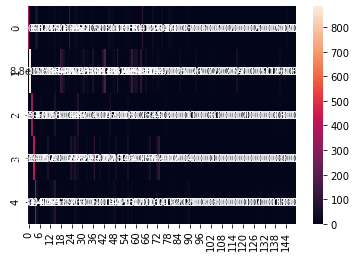

In [9]:
import seaborn as sn
# import pandas as pd
import matplotlib.pyplot as plt
# plt.figure(figsize = (10,7))
sn.heatmap(df.iloc[:5,:], annot=True)

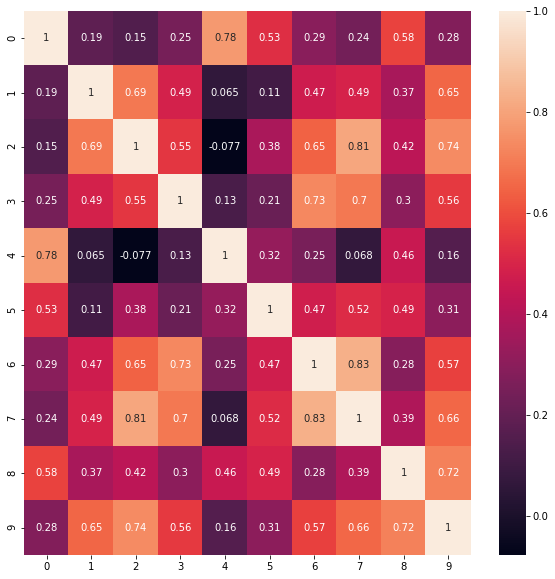

In [42]:
# Viewed the feature matrix in form of a confusion matrix
plt.figure(figsize = (10,10))
sn.heatmap(df1.iloc[:10, :10], annot=True)